In [1]:
from matplotlib import pyplot as plt
plt.rc('axes', titlesize=16) #fontsize of the title
plt.rc('legend', fontsize=16) #fontsize of the legend

import numpy as np
from scipy.stats import expon
import pandas as pd

import sys

sys.path.insert(1,'../src')

from BayersianModel import BayersianModel
from Prior import Prior
from MCMC import NaiveSampler
from models import ChemicalReactionNetwork

from copy import deepcopy
from time import time

# Parameters

## the Gilespe simulation of hydrogens

- $k_1$: binding reaction rate
- $k_2$: breaking reaction rate
- $N_H$: number of $H$
- $N_{H_2}$: number of $H_2$
- $T$: total time of simulation

## parameters for inference

- n_observation
- k1_range
- k2_range
- box_size

In [2]:
k1 = 1
k2 = 2
theta = np.array([k1,k2])
NH = 10
NH2 = 10
X_init =  np.array([NH,NH2])
T = 20

reactions = [
    ({'H':2}, {'H2':1}),
    ({"H2":1},{"H":2})
]

chemicals = 'H H2'.split()

# here are some other parameters that is unrelevant to gilespe
n_observation = 1
k1_range = (.1,10)
k2_range = (.1,10)
parameter_range = np.array((k1_range,k2_range)).T
box_size = 0.12

In [3]:
def parameters2str(theta=theta,X_init=X_init,T=T):
    sep = ', '
    return '   k1 = ' + str(theta[0]) + sep + 'k2 = ' + str(theta[1]) + sep + '#H = ' + str(X_init[0]) + sep + '#H2 = ' + str(X_init[1]) + sep + 'T = ' + str(T) + ' '

In [4]:
Chemical_model = ChemicalReactionNetwork(
    theta,
    reactions,
    chemicals
)

In [5]:
x,r,t = Chemical_model.gilespie(X_init,T)

Text(0.5, 1.0, 'Gilespie Simulation for Hydrogen   k1 = 1, k2 = 2, #H = 10, #H2 = 10, T = 20 ')

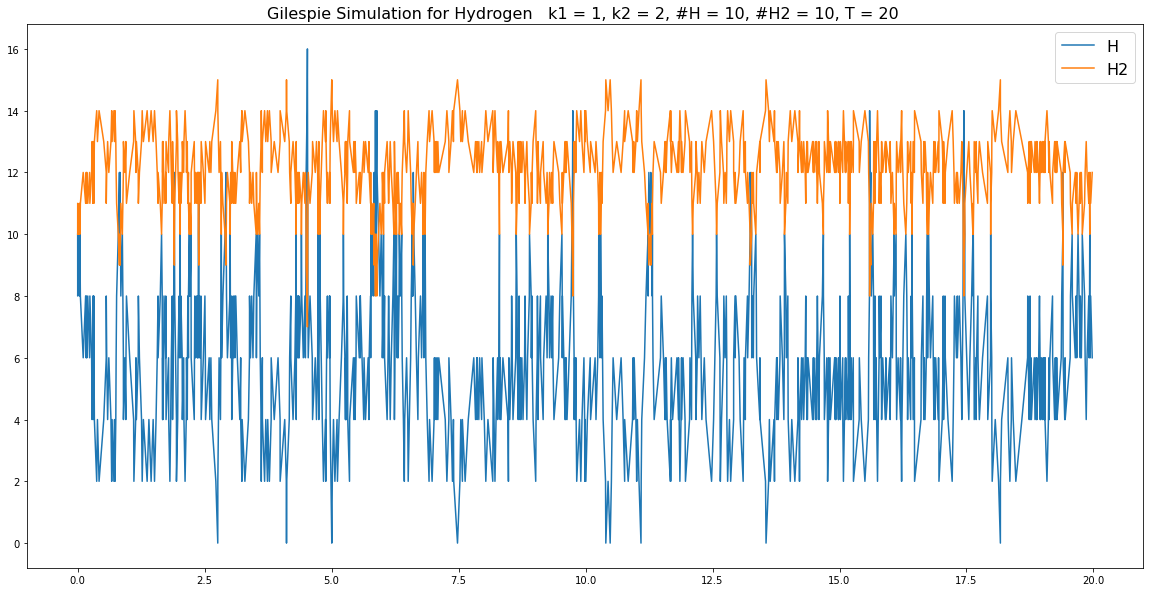

In [6]:
plt.figure(figsize=(20,10))
plt.plot(t,x[:,0],label='H')
plt.plot(t,x[:,1],label='H2')
plt.legend()
plt.title("Gilespie Simulation for Hydrogen" + parameters2str())

In [7]:
observation = [Chemical_model.gilespie(X_init,T) for _ in range(n_observation)]

In [8]:
prior = Prior(
    log_pdf = lambda _ : 0,
    sampler = lambda : (np.random.uniform(*parameter_range)),
    theta_range = parameter_range
)

In [9]:
def log_likelihood(theta,observation):
    theta = np.array(theta)
    return sum([Chemical_model.log_likelihood(
            theta,x,r,t,T) for x,r,t in observation])
    

In [10]:
model = BayersianModel(
    prior = prior,
    observation = observation,
    log_likelyhood = log_likelihood)

In [11]:
model.posterior_heatmap(true_theta=theta)

computing posterior:   5%|▍         | 1960/40000 [00:30<09:47, 64.75it/s]

KeyboardInterrupt: 

computing posterior:   5%|▍         | 1960/40000 [00:50<09:47, 64.75it/s]

In [ ]:
n_big = 0.
N = 20
for i in range(20):
    theta_ = np.random.uniform([0.2,2],[1,3])
    a = log_likelihood(theta_,observation)
    b = log_likelihood(theta_ + 0.1*(np.random.uniform(size=2)-0.5),observation)
    d = np.exp(np.abs(a-b))
    if d > 10:
        s = 'big'
        n_big += 1    
    else:
        s = ''
    print(a,b,d,s,sep='\t')
n_big/N

2109.816866039713	2104.2334186008184	265.98700092772873	big
2387.480964669559	2386.6494819733825	2.2967215572401254	
2288.31680823053	2269.0312028826334	237482702.6636465	big
2306.6131734489404	2305.6177739593463	2.705805066363521	
2351.8827648053953	2353.576437974757	5.439423980705248	
2262.9009432740268	2238.1712937522507	54947802262.6539	big
2230.0874176871325	2216.2383553278387	1034121.0111821442	big
2374.237818029723	2373.399480329372	2.3125196793342715	
2338.7733765203625	2345.911406497882	1258.9457930023798	big
2351.1692298800426	2355.8877143969594	111.9983923211652	big
2339.9169745392433	2348.654713964369	6233.787828164074	big
2287.0483201657858	2274.0744058639893	431021.95255728427	big
2389.845657276016	2389.5857667782784	1.2967880776624223	
2342.4397750978883	2339.6753678743275	15.869630059097672	big
2371.4474425986123	2372.7061273131753	3.520787599934345	
2379.6983588020403	2374.081727025362	274.96168939703176	big
2328.0155880361526	2315.2911605687946	335852.5379148725	big
2

0.65

$$
k_1(x)(x-1) = k_2(N-x)/2
$$

## inference

this inference is very slow because evaluating the log_posterior_proba is too expansive. 

In [ ]:
mcmc = NaiveSampler(model=model)

init_pos = theta + np.uniform(-1,1,size=2)

posterior_samples = mcmc.simulation(theta_range='positive',box_size=box_size, n=int(1e6),init_position=init_pos)

computing posterior:   1%|          | 286/40000 [00:15<34:46, 19.04it/s]

## plot

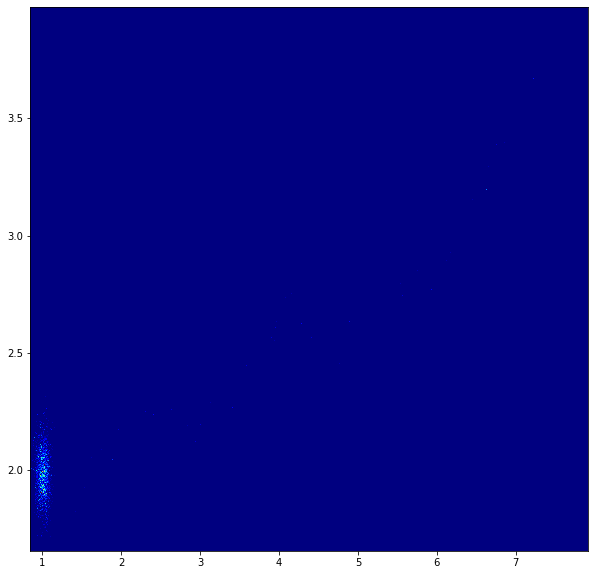

In [ ]:
XX, YY = posterior_samples.T
plt.figure(figsize=(10,10))
ax = plt.hist2d(XX,YY,bins=(1000,1000),cmap='jet')
print()

In [ ]:
import statsmodels.api as sm

ModuleNotFoundError: No module named 'statsmodels'

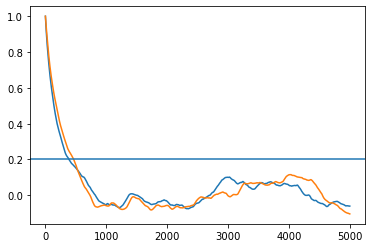

In [ ]:
plt.plot(sm.tsa.acf(posterior_samples[:,1],nlags=5000))
plt.plot(sm.tsa.acf(posterior_samples[:,0],nlags=5000))
# plt.xscale('log')
plt.axhline(0.2)
